# **Matrix Factorization**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.sparse.linalg import svds
import warnings
warnings.filterwarnings('ignore')

Load the entire dataset

In [2]:
movielen = open(r'ml-100K/u.data')
data = pd.DataFrame(movielen)
data = data[0].str.split('\t')

col = ['user id' , 'movie id', 'rating', 'timestamp']
rows = ['data %d' %i for i in range(1,100001)]
df = pd.DataFrame(index=rows, columns=col, dtype=int)

for i in range(100000):
  df.iloc[i] = (data[i])

df['timestamp'] = df['timestamp'].apply(pd.to_numeric)
df['movie id'] = df['movie id'].apply(pd.to_numeric)
df


,user id,movie id,rating,timestamp
data 1,196,242,3,881250949
data 2,186,302,3,891717742
data 3,22,377,1,878887116
data 4,244,51,2,880606923
data 5,166,346,1,886397596
...,...,...,...,...
data 99996,880,476,3,880175444
data 99997,716,204,5,879795543
data 99998,276,1090,1,874795795
data 99999,13,225,2,882399156


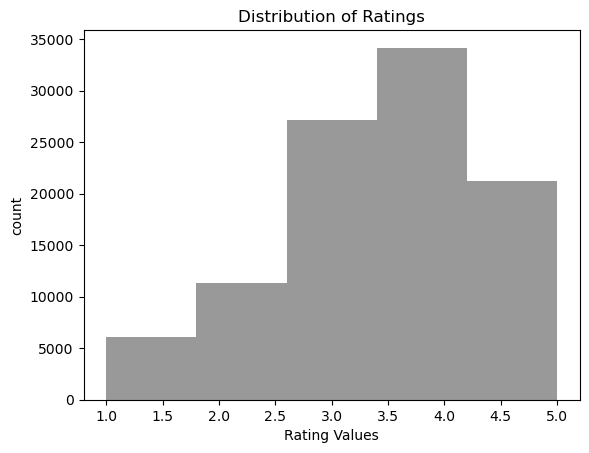

In [3]:
sns.distplot(df['rating'], kde=False, color='black', bins=5)
plt.xlabel('Rating Values')
plt.ylabel('count')
plt.title('Distribution of Ratings')
plt.show();

In [4]:
rating_matrix = df.pivot_table(index = 'user id',
                                columns='movie id',
                                  values='rating').fillna(0)
rating_matrix

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,3.0,2.0,0.0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.0,2.0,1.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,5.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The plot illustrates that Movie IDs up to number 400 have the highest ratings among all users

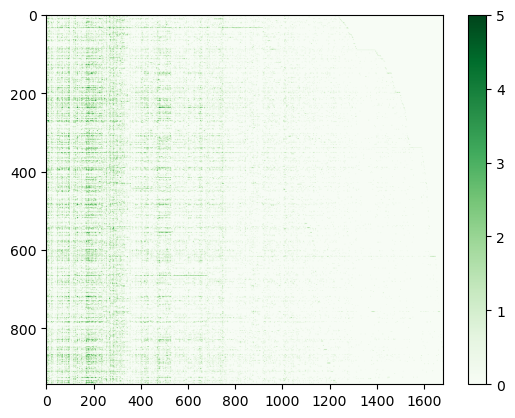

In [14]:
plt.imshow(rating_matrix, cmap="Greens", aspect="auto")
plt.colorbar()
plt.show()

Cross Validation over the given training data for evaluating the number of latent factors for NMF.


In [23]:
num_factors_range = range(10, 101, 10)
cv_errors_train = []
cv_errors_test = []
for fold in range(1, 6):
    train_ratings = pd.read_csv(f"ml-100K/u{fold}.base",
                                 delimiter="\t",
                                  header=None, 
                                  names=["userId", "movieId", "rating", "timestamp"])
    train_matrix = train_ratings.pivot_table(index='userId',
                                              columns='movieId',
                                                values='rating')
    train_matrix.fillna(0, inplace=True)
    test_ratings = pd.read_csv(f"ml-100K/u{fold}.test",
                                delimiter="\t",
                                  header=None,
                                  names=["userId", "movieId", "rating", "timestamp"])
    test_matrix = test_ratings.pivot_table(index='userId',
                                            columns='movieId',
                                              values='rating')
    test_matrix.fillna(0, inplace=True)
    
    fold_errors_train = []
    fold_errors_test = []
    for n in num_factors_range:
        errors_train = []
        errors_test = []
        nmf = NMF(n_components=n, init='random', random_state=0)
        user_factors = nmf.fit_transform(train_matrix)
        movie_factors = nmf.components_
        predicted_ratings = np.dot(user_factors, movie_factors)
        errors_train.append(np.sqrt(((predicted_ratings - train_matrix) ** 2).mean()))
        fold_errors_train.append(np.mean(errors_train))

        user_factors = nmf.fit_transform(test_matrix)
        movie_factors = nmf.components_
        predicted_ratings = np.dot(user_factors, movie_factors)
        errors_test.append(np.sqrt(((predicted_ratings - test_matrix) ** 2).mean()))
        fold_errors_test.append(np.mean(errors_test))
    
    cv_errors_train.append(fold_errors_train)
    cv_errors_test.append(fold_errors_test)


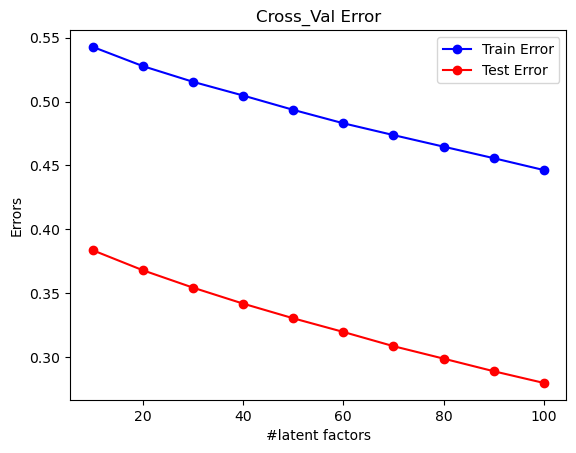

In [24]:
mean_err_train = np.mean(cv_errors_train, axis=0)
mean_err_test = np.mean(cv_errors_test, axis=0)

plt.plot(num_factors_range, mean_err_train, 'bo-')
plt.plot(num_factors_range, mean_err_test, 'ro-')
plt.title('Cross_Val Error')
plt.legend(['Train Error', 'Test Error'])
plt.xlabel('#latent factors')
plt.ylabel('Errors')
plt.show()

According to the above plot the best latent factor number appropriate for the data is **n = 100**

In [25]:
nmf = NMF(n_components=100, init='random', random_state=0)
user_factors = nmf.fit_transform(rating_matrix)
movie_factors = nmf.components_
predicted_ratings = np.dot(user_factors, movie_factors)
predicted_ratings_nmf = pd.DataFrame(predicted_ratings,
                                     index=rating_matrix.index,
                                     columns=rating_matrix.columns)

predicted_ratings_nmf


movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,4.852706,1.881633,1.690939,3.021648,0.852031,0.991796,5.349478,2.310698,2.950840,2.352829,...,0.013136,0.001143,0.042468,0.028312,0.030012,0.002779,0.008338,0.005559,0.029609,0.075842
10,1.133928,0.398469,0.273090,3.677746,1.030310,0.616422,2.010429,2.855134,4.076483,1.134342,...,0.018235,0.003155,0.142949,0.095299,0.052221,0.000123,0.000370,0.000247,0.008760,0.014069
100,0.121997,0.005618,0.005457,0.177303,0.022165,0.027978,0.111006,0.061380,0.004420,0.103061,...,0.001904,0.000000,0.024671,0.016447,0.006788,0.017868,0.053604,0.035736,0.002779,0.000703
101,3.872584,0.017484,0.262785,0.048897,0.109700,0.012150,2.379824,0.186611,0.005102,0.220244,...,0.000000,0.000000,0.048016,0.032011,0.007257,0.000005,0.000016,0.000011,0.000000,0.000000
102,1.442111,1.826918,0.259735,2.616178,1.244027,0.015869,2.078372,1.203822,0.129280,0.108826,...,0.003255,0.001036,0.015477,0.010318,0.008202,0.005807,0.017422,0.011615,0.009146,0.001319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.075160,2.573307,0.177762,1.402313,0.629626,0.179901,3.217599,3.879794,0.175902,0.650351,...,0.020926,0.145611,0.000000,0.000000,0.012564,0.000000,0.000000,0.000000,0.040883,0.023189
96,2.644572,0.285822,0.000160,0.676939,0.277665,0.066958,2.684751,1.243315,0.139253,0.444070,...,0.010690,0.003905,0.007457,0.004971,0.028206,0.000000,0.000000,0.000000,0.023735,0.002343
97,3.712490,0.309188,0.010755,0.733259,0.001199,0.095974,2.456711,1.659960,0.155053,0.048333,...,0.024055,0.012881,0.000107,0.000071,0.002175,0.000001,0.000004,0.000003,0.001159,0.005001


# **SVD Decomposition**

Cross Validation over the given training data for evaluating the number of latent factors for SVD.


In [27]:
num_factors_range = range(10, 101, 10)
cv_errors_train = []
cv_errors_test = []
for fold in range(1, 6):
    train_ratings = pd.read_csv(f"ml-100K/u{fold}.base",
                                  delimiter="\t",
                                  header=None,
                                  names=["userId", "movieId", "rating", "timestamp"])
    train_matrix = train_ratings.pivot_table(index='userId',
                                              columns='movieId',
                                                values='rating')
    train_matrix.fillna(0, inplace=True)
    test_ratings = pd.read_csv(f"ml-100K/u{fold}.test",
                                  delimiter="\t",
                                  header=None,
                                  names=["userId", "movieId", "rating", "timestamp"])
    test_matrix = test_ratings.pivot_table(index='userId',
                                            columns='movieId',
                                              values='rating')
    test_matrix.fillna(0, inplace=True)
    
    fold_errors_train = []
    fold_errors_test = []

    for n in num_factors_range:
        errors_train = []
        errors_test = []
        U, S, Vt = np.linalg.svd(train_matrix)
        U = U[:, :n]
        S = np.diag(S[:n])
        Vt = Vt[:n, :]
        predicted_ratings = np.dot(np.dot(U, S), Vt)
        errors_train.append(np.sqrt(((predicted_ratings - train_matrix) ** 2).mean()))
        fold_errors_train.append(np.mean(errors_train))


        U, S, Vt = np.linalg.svd(test_matrix)
        U = U[:, :n]
        S = np.diag(S[:n])
        Vt = Vt[:n, :]
        predicted_ratings = np.dot(np.dot(U, S), Vt)
        errors_test.append(np.sqrt(((predicted_ratings - test_matrix) ** 2).mean()))
        fold_errors_test.append(np.mean(errors_test))
    
    cv_errors_train.append(fold_errors_train)
    cv_errors_test.append(fold_errors_test)


According to the above plot the best latent factor number appropriate for the data is **n = 100**

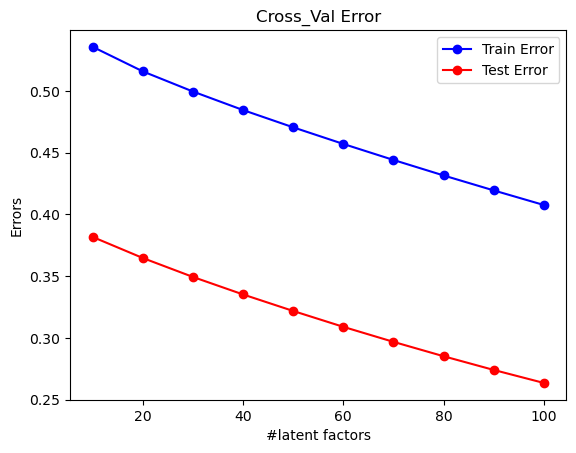

In [28]:
cv_errors_train = np.array(cv_errors_train)
mean_err_train = np.mean(cv_errors_train, axis=0)
cv_err_test = np.array(cv_errors_test)
mean_err_test = np.mean(cv_errors_test, axis=0)

plt.plot(num_factors_range, mean_err_train, 'bo-')
plt.plot(num_factors_range, mean_err_test, 'ro-')
plt.title('Cross_Val Error')
plt.legend(['Train Error', 'Test Error'])
plt.xlabel('#latent factors')
plt.ylabel('Errors')
plt.show()

In [29]:
U, S, Vt = np.linalg.svd(rating_matrix)
num_factors = 100

U = U[:, :num_factors]
S = np.diag(S[:num_factors])
Vt = Vt[:num_factors, :]

predicted_ratings = np.dot(np.dot(U, S), Vt)
predicted_ratings_svd = pd.DataFrame(predicted_ratings,
                                     index=rating_matrix.index,
                                       columns=rating_matrix.columns)
predicted_ratings_svd

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.258054,3.209353,2.374820,4.040103,2.209635,2.386851,4.893328,2.416666,4.962925,2.170820,...,0.017151,-0.004007,-0.056501,-0.037667,0.032034,0.004093,0.012278,0.008185,0.031342,0.171292
10,3.250425,-0.023604,0.812884,3.516662,-0.519176,-0.158657,4.831167,3.037875,3.752510,0.243496,...,0.039890,-0.048770,0.113704,0.075803,0.075696,-0.012052,-0.036157,-0.024104,-0.037212,-0.036372
100,0.287732,-0.249566,0.208452,0.195911,-0.079648,-0.190325,0.184558,-0.097484,-0.108932,-0.015239,...,0.015011,-0.001731,0.025180,0.016787,0.008613,0.018327,0.054980,0.036654,-0.012044,0.004389
101,3.376619,-0.232988,0.393539,-0.584100,0.063087,-0.279002,2.497798,0.459450,-0.035223,0.039315,...,-0.006488,0.050997,0.022799,0.015199,0.009809,0.002730,0.008190,0.005460,0.005899,0.005720
102,2.360913,2.676717,-0.401895,2.858641,1.176993,-0.271963,1.859583,0.274606,-0.031865,0.039312,...,0.003023,-0.037995,0.022829,0.015219,-0.011866,0.003430,0.010291,0.006861,0.014977,-0.019931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.745404,1.386182,0.198713,2.043748,-0.234055,-0.351958,4.008441,4.555165,0.918034,-0.448169,...,-0.015965,0.197205,-0.065890,-0.043926,0.027596,0.003318,0.009955,0.006637,0.029032,-0.051032
96,4.385426,0.465704,-0.520670,-0.280921,1.047411,-0.113877,2.426354,1.676044,-0.138943,0.111402,...,-0.001225,0.064688,-0.020966,-0.013977,0.044833,0.002604,0.007811,0.005207,0.013858,-0.022775
97,4.108895,0.470665,0.292533,1.383253,0.301465,-0.037789,3.624877,0.464184,0.952430,0.544596,...,-0.012029,0.083411,-0.048948,-0.032632,0.044562,0.002435,0.007306,0.004871,-0.065175,-0.005433


As it has been demonstrated in the above plots that NMF and SVD tend to have the same results based on errors(Mean Square Error). 

In other words, NMF had quit higher error rates in comparison to SVD but both show decrease in test and train errors. 

Although Based on both algorithms we could identify the same latent factor, SVD happens to be less time_consuming method.

Also based on the below described dataframes, NMF and SVD roughly provide the same preference scores of each user on all 
movies.

In [30]:
predicted_ratings_nmf.describe()

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
count,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,...,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000
mean,1.911568,0.510706,0.350229,0.890905,0.351876,0.133598,1.666533,1.019874,1.306076,0.442060,...,0.009416,0.014318,0.014866,0.009911,0.010887,0.003556,0.010669,0.007113,0.008603,0.010957
std,1.545446,0.870821,0.614445,1.117779,0.684686,0.264695,1.599095,1.175514,1.668346,0.648091,...,0.015879,0.063314,0.024722,0.016481,0.011333,0.005171,0.015514,0.010343,0.018621,0.027835
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.443311,0.012833,0.010507,0.112777,0.016658,0.016401,0.181585,0.107535,0.022614,0.056751,...,0.000452,0.000000,0.000199,0.000132,0.002732,0.000000,0.000000,0.000000,0.000434,0.000135
50%,1.659932,0.096980,0.103672,0.349825,0.061847,0.049770,1.146002,0.513603,0.224141,0.212271,...,0.002015,0.000000,0.005973,0.003982,0.007622,0.001250,0.003749,0.002499,0.001738,0.001654
75%,3.149168,0.540230,0.383091,1.341199,0.314985,0.167817,2.862993,1.684494,2.414614,0.552360,...,0.011440,0.001993,0.018134,0.012089,0.015737,0.005489,0.016466,0.010978,0.009044,0.008089
max,6.501858,5.248631,5.104151,5.454768,4.999035,4.430836,6.678525,7.010461,5.907495,5.125834,...,0.124255,0.992346,0.261388,0.174258,0.110533,0.037107,0.111321,0.074214,0.312812,0.281158


In [31]:
predicted_ratings_svd.describe()

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
count,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,...,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000
mean,1.862326,0.450930,0.299033,0.790238,0.296417,0.097944,1.591065,0.924391,1.224368,0.347090,...,0.003441,0.004724,0.000860,0.000574,0.003125,0.001759,0.005276,0.003517,0.002449,0.001607
std,1.871356,0.987037,0.718825,1.340388,0.769144,0.367739,1.781310,1.564519,1.739137,0.872304,...,0.039535,0.061454,0.052467,0.034978,0.040690,0.007012,0.021036,0.014024,0.043529,0.045144
min,-1.850713,-1.245058,-1.409115,-1.462352,-1.780728,-1.118739,-1.777659,-1.501446,-2.052908,-1.491895,...,-0.176730,-0.198006,-0.238736,-0.159157,-0.130281,-0.024465,-0.073396,-0.048931,-0.175637,-0.141984
25%,0.221094,-0.104849,-0.088588,-0.064570,-0.132810,-0.087884,0.105653,-0.096687,-0.033051,-0.130999,...,-0.015148,-0.023760,-0.025342,-0.016895,-0.017652,-0.002407,-0.007222,-0.004815,-0.019514,-0.022165
50%,1.251357,0.109993,0.124425,0.272143,0.099590,0.045050,0.902581,0.292346,0.546787,0.140695,...,0.001652,-0.000580,-0.001903,-0.001269,-0.001751,0.001037,0.003110,0.002073,0.001036,-0.000863
75%,3.474660,0.524638,0.443979,1.245935,0.426910,0.211400,3.088089,1.362780,2.446806,0.564612,...,0.019298,0.028582,0.023812,0.015875,0.020994,0.005062,0.015185,0.010123,0.020418,0.019188
max,6.668207,5.510673,4.322086,6.489886,4.929651,4.058653,6.767446,6.602903,6.946131,5.940159,...,0.494499,0.894661,0.864605,0.576403,0.522962,0.049233,0.147700,0.098467,0.596847,0.640726
